In [1]:
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import os

from dataclasses import asdict

import mlflow
import torch

from einops import reduce, repeat

from flow_mnist.config import load_config
from flow_mnist.data import MNISTDataset
from flow_mnist.flow import MNISTSampleable, NormalSampleable, OTFlowPath
from flow_mnist.model import AutoEncoder, FlowModel
from flow_mnist.ode import ODE
from flow_mnist.train import Trainer
from flow_mnist.utils import plot_batch

In [3]:
torch.manual_seed(88)
os.chdir("..") if not os.path.exists("config.yaml") else None
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
conf = load_config("config.yaml")

In [4]:
mlflow.set_tracking_uri(conf.log.server.uri)
mlflow.set_experiment("MNIST Flow Matching")

<Experiment: artifact_location='mlflow-artifacts:/417261536112185923', creation_time=1750021081611, experiment_id='417261536112185923', last_update_time=1750021081611, lifecycle_stage='active', name='MNIST Flow Matching', tags={}>

In [5]:
data_mnist = MNISTDataset(**asdict(conf.data))

ot_path = OTFlowPath()
p_init_norm = NormalSampleable((4, 4, 4))
p_data_mnist = MNISTSampleable(dataset=data_mnist)

vae = AutoEncoder(**asdict(conf.model.vae)).to(device)
flow_model = FlowModel(**asdict(conf.model.flow)).to(device)

In [6]:
trainer = Trainer(
    logger=conf.log.param,
    **asdict(conf.train),
    p_data=p_data_mnist,
    p_init=p_init_norm,
    f_model=flow_model,
    f_path=ot_path,
    device=device,
    vae=vae,
)

In [ ]:
with mlflow.start_run():
    mlflow.log_params(asdict(conf.model.flow))
    mlflow.log_params(asdict(conf.train))
    mlflow.set_tag("debug", True)
    trainer.train()

In [8]:
torch.save(flow_model.state_dict(), conf.path.storage / "flow_cfg.pt")

In [7]:
state_dict = torch.load(conf.path.storage / "flow_cfg.pt")
flow_model.load_state_dict(state_dict)

<All keys matched successfully>

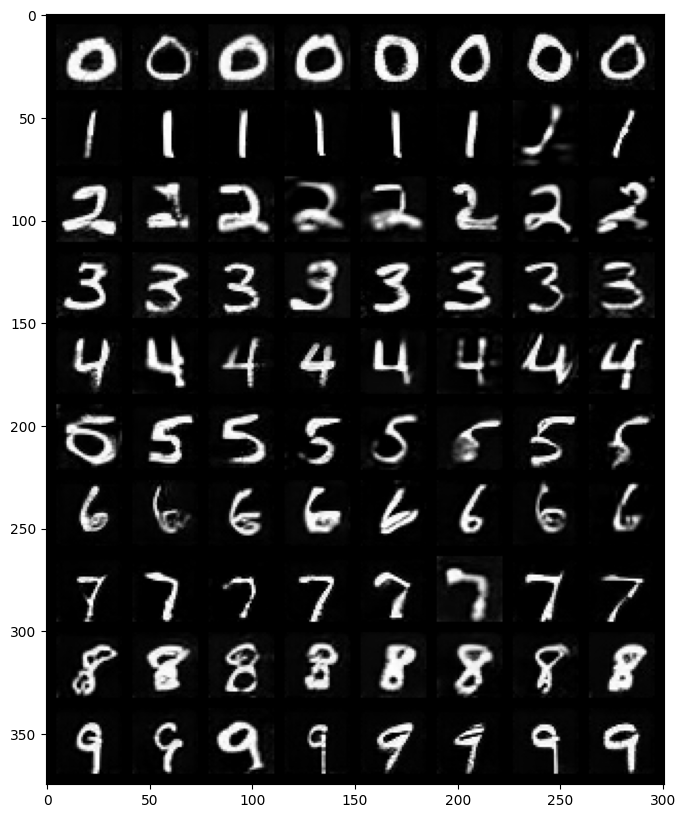

In [9]:
bs = 8
ode = ODE(model=flow_model, method="euler")

t = torch.linspace(0, 1, 1000, device=device)
y = torch.arange(0, 10, device=device)
y = repeat(y, "y -> (y b)", b=bs)

x_0 = p_init_norm.sample(y.nelement()).flatten(1).to(device)

x_1 = ode.sample(x_0, t, y, w=2.25)
x_1 = x_1.reshape((-1, 4, 4, 4))
x_1 = vae.decode(x=x_1).cpu()
x_1 = reduce(x_1, "b c h w -> b 1 h w", "mean")

plot_batch(x_1, bs, figsize=(20, 10));